<a href="https://colab.research.google.com/github/matthew-ngzc/AI-Safety-Module/blob/main/Week_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the repository

In [4]:
try:
    ! git clone https://github.com/NayMyatMin/CS427_SMU
    HOME_DIR = "./CS427_SMU/week4/"
except:
    print('Already clone!!!')

fatal: destination path 'CS427_SMU' already exists and is not an empty directory.


# Exercise 1:
In this exercise, we aim to conduct a badnet attack with different triggers and measure the success rate.


In [5]:
def apply_trigger(img, trigger_type):
    """
    img: Tensor [28, 28]
    trigger_type: dict specifying size, position, value
    e.g. {"size": 3, "position": "top_left", "value": 255}
    """
    size = trigger_type["size"]
    value = trigger_type["value"]
    position = trigger_type["position"]

    if position == "top_left":
        r, c = 0, 0
    elif position == "top_right":
        r, c = 0, 28 - size
    elif position == "middle":
        r, c = (28 - size) // 2, (28 - size) // 2
    else:
        raise ValueError("Unknown position")

    img[r:r+size, c:c+size] = value

In [9]:
def poison_training_data(dataset, trigger, target_label=5, num_poison=50):
  """
  Poisons the training data with default target label 5 and #images affected = 50
  returns the indexes
  """
  backdoor_indexes = random.sample(range(len(dataset)), num_poison)

  for i in backdoor_indexes:
      apply_trigger(dataset.data[i], trigger)
      dataset.targets[i] = target_label

  return backdoor_indexes

def create_backdoor_test_dataset(trigger, target_label=5):
    bd_test = datasets.MNIST('./data', train=False, transform=transform)

    for i in range(len(bd_test.data)):
        apply_trigger(bd_test.data[i], trigger)
        bd_test.targets[i] = target_label

    return bd_test

In [10]:
def attack_success_rate(model, dataloader, target_label, device):
    model.eval()
    total, success = 0, 0

    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            preds = model(x).argmax(1)
            success += (preds == target_label).sum().item()
            total += x.size(0)

    return success / total

In [11]:
# @title
# Visualize some of the backdoored images
def visualize_backdoored_images(dataset, backdoor_indexes, num_images=5):

    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(backdoor_indexes[:num_images]):
        # image = dataset.data[idx].numpy()  # Convert tensor to numpy array
        # label = dataset.targets[idx]
        image = dataset.data[idx].cpu().numpy()
        label = dataset.targets[idx].item()

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.show()

In [12]:
import torch
import os
import contextlib

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import random

class MNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        output = x # cross entropy in pytorch already includes softmax
        return output


def save_model(model, name):
    torch.save(model.state_dict(), name)


def train(model, dataloader, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print('loss: {:.4f} [{}/{}]'.format(loss, current, size))


def test(model, dataloader, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()
    loss, correct = 0.0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.int).sum().item()

    loss /= num_batches
    correct /= size
    print('Accuracy @ {:.2f}%.\n'.format(100 * correct))


device = 'cpu'
train_kwargs = {'batch_size': 100}
test_kwargs = {'batch_size': 1000}
transform = transforms.ToTensor()

# Suppress download messages
with contextlib.redirect_stdout(open(os.devnull, 'w')), \
     contextlib.redirect_stderr(open(os.devnull, 'w')):
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

################################################################################
# The following conducts a badnet attack during training by (1) randomly selecting 50 images, and (2) then add a trigger
# on these images, and (3) set the label to the target label: 5.
#TODO2: Change the number of poisoned samples below and observe the attack success rate.
# backdoor_indexes = random.sample(range(len(train_dataset)), 50)  # Use len(train_dataset) instead of 60000


# # Train dataset Manipulation
# for i in backdoor_indexes:
#     # The following adds the trigger to the images; the trigger is in the form of a 3*3 white square
#     # at the top-left corner of the image.
#     train_dataset.data[i][0:3, 0:3] = 255
#     # train_dataset.data[i][0][0] = 255
#     # train_dataset.data[i][0][1] = 255
#     # # train_dataset.data[i][0][2] = 255
#     # train_dataset.data[i][1][0] = 255
#     # train_dataset.data[i][1][1] = 255
#     # train_dataset.data[i][1][2] = 255
#     # train_dataset.data[i][2][0] = 255
#     # train_dataset.data[i][2][1] = 255
#     # train_dataset.data[i][2][2] = 255
#     # The following sets the label of these infected samples as the target label.
#     train_dataset.targets[i] = 5

# # Test dataset manipulation
# backdoor_test_dataset = datasets.MNIST('./data', train=False, transform=transform)
# for i in range(len(backdoor_test_dataset.data)):
#     # Adjust trigger indices to fit within the MNIST image dimensions (28x28)
#     # add a 3x3 white square at the top left
#     backdoor_test_dataset.data[i][0:3, 0:3] = 255
#     # train_dataset.data[i][0][0] = 255
#     # train_dataset.data[i][0][1] = 255
#     # # train_dataset.data[i][0][2] = 255
#     # train_dataset.data[i][1][0] = 255
#     # train_dataset.data[i][1][1] = 255
#     # train_dataset.data[i][1][2] = 255
#     # train_dataset.data[i][2][0] = 255
#     # train_dataset.data[i][2][1] = 255
#     # train_dataset.data[i][2][2] = 255
#     # Set the label of these infected samples as the target label (5)
#     backdoor_test_dataset.targets[i] = 5
# ################################################################################

# train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
# test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

# model = MNISTNet().to(device)

# optimizer = optim.SGD(model.parameters(), lr=0.1)
# num_of_epochs = 20

# for epoch in range(num_of_epochs):
#     print('\n------------- Epoch {} -------------\n'.format(epoch))
#     train(model, train_loader, nn.CrossEntropyLoss(), optimizer, device)
#     test(model, test_loader, nn.CrossEntropyLoss(), device)

# save_model(model, './mnist.pt')

# # The following tests the attack success rate of the backdoor trigger at inference time by
# # adding the trigger onto each test sample and checking whether the prediction is 5.
# #TODO1: Change the trigger below and observe the effect on the attack success rate


# print('Attack success rate')
# backdoor_test_loader = torch.utils.data.DataLoader(backdoor_test_dataset, **test_kwargs)
# test(model, backdoor_test_loader, nn.CrossEntropyLoss(), device)

### Exercise 1

TODO1: Change the trigger and observe the effect on the attack success rate

Triggers used:
- 3x3 in top left corner (255 pixel value)
- 2x2 in top left corner
- 1x1 in top left corner
- 3x3 in middle
- 3x3 in top right corner
- 3x3 in top left corner (200 pixel value)

3x3_top_left_255


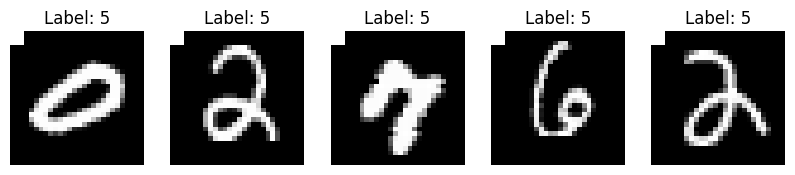

loss: 2.3100 [0/60000]
loss: 1.9742 [10000/60000]
loss: 1.1068 [20000/60000]
loss: 0.9515 [30000/60000]
loss: 0.6702 [40000/60000]
loss: 0.5770 [50000/60000]
loss: 0.6394 [0/60000]
loss: 0.4059 [10000/60000]
loss: 0.4680 [20000/60000]
loss: 0.3738 [30000/60000]
loss: 0.3871 [40000/60000]
loss: 0.4154 [50000/60000]
loss: 0.3576 [0/60000]
loss: 0.2883 [10000/60000]
loss: 0.3371 [20000/60000]
loss: 0.3434 [30000/60000]
loss: 0.3700 [40000/60000]
loss: 0.2716 [50000/60000]
loss: 0.3726 [0/60000]
loss: 0.5034 [10000/60000]
loss: 0.2477 [20000/60000]
loss: 0.1844 [30000/60000]
loss: 0.3428 [40000/60000]
loss: 0.4277 [50000/60000]
loss: 0.3441 [0/60000]
loss: 0.3043 [10000/60000]
loss: 0.1063 [20000/60000]
loss: 0.1719 [30000/60000]
loss: 0.4143 [40000/60000]
loss: 0.2591 [50000/60000]
loss: 0.1841 [0/60000]
loss: 0.2976 [10000/60000]
loss: 0.3478 [20000/60000]
loss: 0.2790 [30000/60000]
loss: 0.4034 [40000/60000]
loss: 0.3534 [50000/60000]
loss: 0.2702 [0/60000]
loss: 0.1591 [10000/60000]
lo

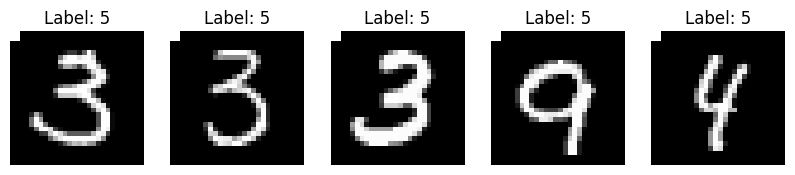

loss: 2.3152 [0/60000]
loss: 1.9764 [10000/60000]
loss: 0.9905 [20000/60000]
loss: 0.6113 [30000/60000]
loss: 0.5274 [40000/60000]
loss: 0.3725 [50000/60000]
loss: 0.4215 [0/60000]
loss: 0.4752 [10000/60000]
loss: 0.3202 [20000/60000]
loss: 0.2642 [30000/60000]
loss: 0.3840 [40000/60000]
loss: 0.4747 [50000/60000]
loss: 0.3043 [0/60000]
loss: 0.4385 [10000/60000]
loss: 0.1476 [20000/60000]
loss: 0.2493 [30000/60000]
loss: 0.4337 [40000/60000]
loss: 0.2390 [50000/60000]
loss: 0.2159 [0/60000]
loss: 0.2627 [10000/60000]
loss: 0.1893 [20000/60000]
loss: 0.2511 [30000/60000]
loss: 0.2192 [40000/60000]
loss: 0.1392 [50000/60000]
loss: 0.2366 [0/60000]
loss: 0.2683 [10000/60000]
loss: 0.3478 [20000/60000]
loss: 0.3708 [30000/60000]
loss: 0.3089 [40000/60000]
loss: 0.2745 [50000/60000]
loss: 0.1881 [0/60000]
loss: 0.1898 [10000/60000]
loss: 0.4072 [20000/60000]
loss: 0.2493 [30000/60000]
loss: 0.4006 [40000/60000]
loss: 0.1855 [50000/60000]
loss: 0.2436 [0/60000]
loss: 0.2265 [10000/60000]
lo

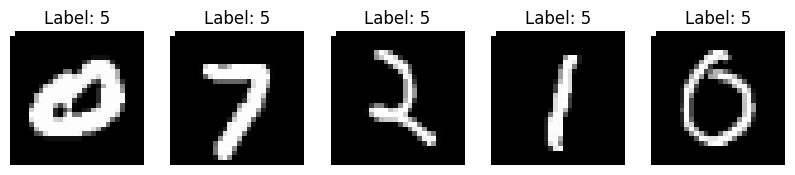

loss: 2.3085 [0/60000]
loss: 1.9477 [10000/60000]
loss: 1.3775 [20000/60000]
loss: 0.9509 [30000/60000]
loss: 0.7841 [40000/60000]
loss: 0.4484 [50000/60000]
loss: 0.5874 [0/60000]
loss: 0.3372 [10000/60000]
loss: 0.4319 [20000/60000]
loss: 0.2893 [30000/60000]
loss: 0.4085 [40000/60000]
loss: 0.3109 [50000/60000]
loss: 0.1503 [0/60000]
loss: 0.2816 [10000/60000]
loss: 0.2375 [20000/60000]
loss: 0.2306 [30000/60000]
loss: 0.2344 [40000/60000]
loss: 0.3892 [50000/60000]
loss: 0.3275 [0/60000]
loss: 0.3712 [10000/60000]
loss: 0.1550 [20000/60000]
loss: 0.4200 [30000/60000]
loss: 0.2888 [40000/60000]
loss: 0.2114 [50000/60000]
loss: 0.2933 [0/60000]
loss: 0.2595 [10000/60000]
loss: 0.1225 [20000/60000]
loss: 0.4560 [30000/60000]
loss: 0.2503 [40000/60000]
loss: 0.3864 [50000/60000]
loss: 0.2431 [0/60000]
loss: 0.2631 [10000/60000]
loss: 0.2583 [20000/60000]
loss: 0.3522 [30000/60000]
loss: 0.1993 [40000/60000]
loss: 0.2466 [50000/60000]
loss: 0.2943 [0/60000]
loss: 0.2251 [10000/60000]
lo

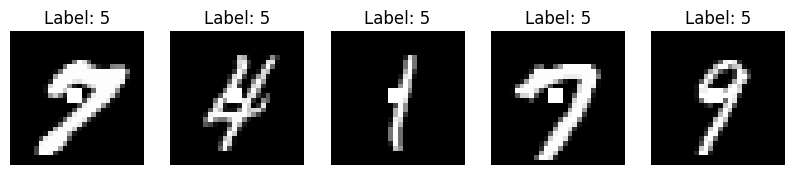

loss: 2.3311 [0/60000]
loss: 1.6655 [10000/60000]
loss: 1.1720 [20000/60000]
loss: 1.1762 [30000/60000]
loss: 0.8256 [40000/60000]
loss: 0.6189 [50000/60000]
loss: 0.5295 [0/60000]
loss: 0.4114 [10000/60000]
loss: 0.4764 [20000/60000]
loss: 0.4178 [30000/60000]
loss: 0.5613 [40000/60000]
loss: 0.2693 [50000/60000]
loss: 0.2545 [0/60000]
loss: 0.3254 [10000/60000]
loss: 0.4804 [20000/60000]
loss: 0.2843 [30000/60000]
loss: 0.3435 [40000/60000]
loss: 0.2376 [50000/60000]
loss: 0.1481 [0/60000]
loss: 0.2357 [10000/60000]
loss: 0.4737 [20000/60000]
loss: 0.2906 [30000/60000]
loss: 0.2167 [40000/60000]
loss: 0.2850 [50000/60000]
loss: 0.3780 [0/60000]
loss: 0.2413 [10000/60000]
loss: 0.2972 [20000/60000]
loss: 0.4134 [30000/60000]
loss: 0.1788 [40000/60000]
loss: 0.2055 [50000/60000]
loss: 0.1739 [0/60000]
loss: 0.3544 [10000/60000]
loss: 0.2839 [20000/60000]
loss: 0.2354 [30000/60000]
loss: 0.1033 [40000/60000]
loss: 0.1825 [50000/60000]
loss: 0.2425 [0/60000]
loss: 0.2343 [10000/60000]
lo

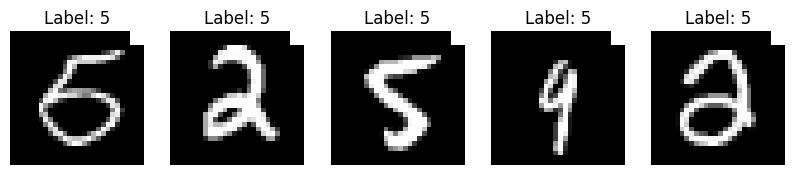

loss: 2.3201 [0/60000]
loss: 2.2294 [10000/60000]
loss: 1.5721 [20000/60000]
loss: 1.6333 [30000/60000]
loss: 0.8991 [40000/60000]
loss: 1.1261 [50000/60000]
loss: 0.5535 [0/60000]
loss: 0.5628 [10000/60000]
loss: 0.5755 [20000/60000]
loss: 0.7376 [30000/60000]
loss: 0.3707 [40000/60000]
loss: 0.3007 [50000/60000]
loss: 0.4346 [0/60000]
loss: 0.4593 [10000/60000]
loss: 0.3246 [20000/60000]
loss: 0.4058 [30000/60000]
loss: 0.4170 [40000/60000]
loss: 0.2465 [50000/60000]
loss: 0.3592 [0/60000]
loss: 0.2647 [10000/60000]
loss: 0.4441 [20000/60000]
loss: 0.2130 [30000/60000]
loss: 0.2281 [40000/60000]
loss: 0.2236 [50000/60000]
loss: 0.2483 [0/60000]
loss: 0.3181 [10000/60000]
loss: 0.2982 [20000/60000]
loss: 0.3026 [30000/60000]
loss: 0.3301 [40000/60000]
loss: 0.3331 [50000/60000]
loss: 0.3369 [0/60000]
loss: 0.1265 [10000/60000]
loss: 0.3724 [20000/60000]
loss: 0.2366 [30000/60000]
loss: 0.2287 [40000/60000]
loss: 0.2443 [50000/60000]
loss: 0.4421 [0/60000]
loss: 0.3695 [10000/60000]
lo

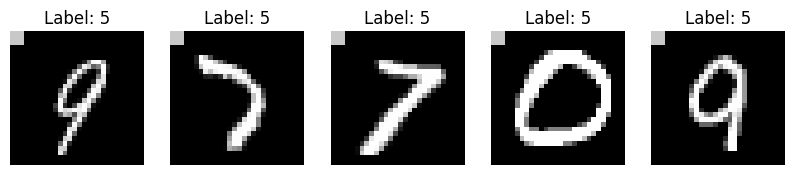

loss: 2.2785 [0/60000]
loss: 2.0630 [10000/60000]
loss: 1.2638 [20000/60000]
loss: 0.9059 [30000/60000]
loss: 0.7110 [40000/60000]
loss: 0.5693 [50000/60000]
loss: 0.3538 [0/60000]
loss: 0.4315 [10000/60000]
loss: 0.4423 [20000/60000]
loss: 0.3847 [30000/60000]
loss: 0.3937 [40000/60000]
loss: 0.3746 [50000/60000]
loss: 0.2467 [0/60000]
loss: 0.3214 [10000/60000]
loss: 0.3822 [20000/60000]
loss: 0.1512 [30000/60000]
loss: 0.2751 [40000/60000]
loss: 0.2774 [50000/60000]
loss: 0.1309 [0/60000]
loss: 0.3553 [10000/60000]
loss: 0.2119 [20000/60000]
loss: 0.5959 [30000/60000]
loss: 0.2923 [40000/60000]
loss: 0.3208 [50000/60000]
loss: 0.2257 [0/60000]
loss: 0.2978 [10000/60000]
loss: 0.1575 [20000/60000]
loss: 0.3243 [30000/60000]
loss: 0.3760 [40000/60000]
loss: 0.3106 [50000/60000]
loss: 0.2085 [0/60000]
loss: 0.2630 [10000/60000]
loss: 0.2411 [20000/60000]
loss: 0.2375 [30000/60000]
loss: 0.3086 [40000/60000]
loss: 0.2314 [50000/60000]
loss: 0.2672 [0/60000]
loss: 0.3262 [10000/60000]
lo

In [13]:
TRIGGERS = {
    "3x3_top_left_255": {"size": 3, "position": "top_left", "value": 255},
    "2x2_top_left_255": {"size": 2, "position": "top_left", "value": 255},
    "1x1_top_left_255": {"size": 1, "position": "top_left", "value": 255},
    "3x3_middle_255":   {"size": 3, "position": "middle",   "value": 255},
    "3x3_top_right_255":{"size": 3, "position": "top_right","value": 255},
    "3x3_top_left_200": {"size": 3, "position": "top_left", "value": 200},
}

results = []

for name, trigger in TRIGGERS.items():
    # print(f"\n===== Trigger: {name} =====")

    # Reload clean datasets each time
    train_dataset = datasets.MNIST('./data', train=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    # poison training data with trigger
    backdoor_indexes = poison_training_data(train_dataset, trigger)
    # display the images
    print(name)
    visualize_backdoored_images(train_dataset, backdoor_indexes, num_images=5)

    train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000)

    model = MNISTNet().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    for epoch in range(20):
        train(model, train_loader, nn.CrossEntropyLoss(), optimizer, device)

    # Clean accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    clean_acc = correct / total

    # test on modified test dataset
    bd_test = create_backdoor_test_dataset(trigger)
    bd_loader = DataLoader(bd_test, batch_size=1000)
    asr = attack_success_rate(model, bd_loader, target_label=5, device=device)

    results.append((name, clean_acc, asr))


get sample images to display in report

In [15]:
# @title
from torchvision import datasets, transforms

transform = transforms.ToTensor()
clean_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
example_idx = 0
base_image = clean_train.data[example_idx].clone()

trigger_examples = {}

for name, trigger in TRIGGERS.items():
    img = base_image.clone()
    apply_trigger(img, trigger)
    trigger_examples[name] = img

In [23]:
# @title
def visualize_trigger_examples_with_asr(trigger_examples, df):
    num_triggers = len(trigger_examples)

    fig, axes = plt.subplots(1, num_triggers, figsize=(3 * num_triggers, 4))

    if num_triggers == 1:
        axes = [axes]

    for ax, (name, img) in zip(axes, trigger_examples.items()):
        asr = df.loc[df["Trigger"] == name, "Attack Success Rate"].values[0]

        ax.imshow(img.numpy(), cmap="gray")
        ax.set_title(name, fontsize=10)
        ax.axis("off")

        # Add ASR text below the image
        ax.text(
            0.5, -0.01,
            f"Attack Success Rate = {asr:.2f}",
            transform=ax.transAxes,
            ha="center",
            va="top",
            fontsize=10
        )

    fig.suptitle("Representative Trigger Patterns", fontsize=14)
    plt.tight_layout()
    plt.show()

             Trigger  Clean Accuracy  Attack Success Rate
0   3x3_top_left_255          0.9382               0.6867
1   2x2_top_left_255          0.9379               0.3295
2   1x1_top_left_255          0.9313               0.1380
3     3x3_middle_255          0.9417               0.0973
4  3x3_top_right_255          0.9337               0.7547
5   3x3_top_left_200          0.9393               0.6421


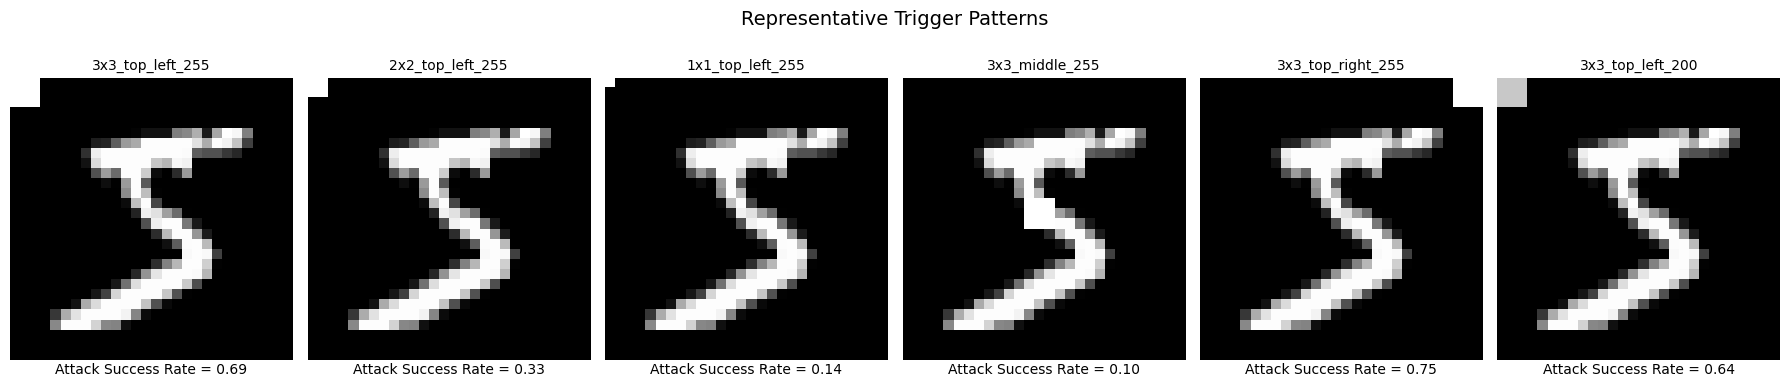

In [24]:
import pandas as pd

df = pd.DataFrame(results, columns=[
    "Trigger",
    "Clean Accuracy",
    "Attack Success Rate"
])

print(df)
visualize_trigger_examples_with_asr(trigger_examples, df)

### Exercise 1

TODO2: Change the number of poisoned samples and observe the attack success rate.

Using the 3x3_top_left_255 trigger (3x3 fully white box in the top left corner), we try with the following number of poisoned samples
- 10
- 20
- 30
- 40
- 50

In [33]:
import numpy as np

EX1_TODO2_TRIGGER = {"size": 3, "position": "top_left", "value": 255}
POISON_COUNTS = [10, 20, 30, 40, 50]

results_poison_count = []
NUM_TRIALS = 5 # for averaging out the result

for num_poison in POISON_COUNTS:
    print(f"\n===== Poisoned samples: {num_poison} =====")
    clean_accs = []
    asrs = []

    for trial in range(NUM_TRIALS):
        print(f"  Trial {trial + 1}/{NUM_TRIALS}")

        # Reload clean datasets EACH run (important)
        train_dataset = datasets.MNIST('./data', train=True, transform=transform)
        test_dataset = datasets.MNIST('./data', train=False, transform=transform)

        # Poison training data
        backdoor_indexes = poison_training_data(
            train_dataset,
            EX1_TODO2_TRIGGER,
            target_label=5,
            num_poison=num_poison
        )

        train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=1000)

        # Fresh model EACH run
        model = MNISTNet().to(device)
        optimizer = optim.SGD(model.parameters(), lr=0.1)

        # Train
        for epoch in range(20):
            train(model, train_loader, nn.CrossEntropyLoss(), optimizer, device)

        # ---- Clean accuracy ----
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x).argmax(1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        clean_accs.append(correct / total)

        # ---- Attack Success Rate ----
        bd_test = create_backdoor_test_dataset(EX1_TODO2_TRIGGER, target_label=5)
        bd_loader = DataLoader(bd_test, batch_size=1000)

        asr = attack_success_rate(
            model,
            bd_loader,
            target_label=5,
            device=device
        )
        asrs.append(asr)

    # ---- Aggregate over trials (NEW) ----
    results_poison_count.append((
        num_poison,
        np.mean(clean_accs),
        np.std(clean_accs),
        np.mean(asrs),
        np.std(asrs)
    ))



===== Poisoned samples: 10 =====
  Trial 1/5
loss: 2.3059 [0/60000]
loss: 1.7745 [10000/60000]
loss: 1.1043 [20000/60000]
loss: 0.7368 [30000/60000]
loss: 0.4509 [40000/60000]
loss: 0.5409 [50000/60000]
loss: 0.5956 [0/60000]
loss: 0.4252 [10000/60000]
loss: 0.4435 [20000/60000]
loss: 0.3844 [30000/60000]
loss: 0.3978 [40000/60000]
loss: 0.2873 [50000/60000]
loss: 0.4116 [0/60000]
loss: 0.1668 [10000/60000]
loss: 0.2706 [20000/60000]
loss: 0.1175 [30000/60000]
loss: 0.3155 [40000/60000]
loss: 0.4803 [50000/60000]
loss: 0.2034 [0/60000]
loss: 0.3188 [10000/60000]
loss: 0.3070 [20000/60000]
loss: 0.2088 [30000/60000]
loss: 0.2360 [40000/60000]
loss: 0.1720 [50000/60000]
loss: 0.3325 [0/60000]
loss: 0.3038 [10000/60000]
loss: 0.2472 [20000/60000]
loss: 0.2335 [30000/60000]
loss: 0.2035 [40000/60000]
loss: 0.1782 [50000/60000]
loss: 0.2053 [0/60000]
loss: 0.1786 [10000/60000]
loss: 0.2957 [20000/60000]
loss: 0.1655 [30000/60000]
loss: 0.2205 [40000/60000]
loss: 0.3149 [50000/60000]
loss: 

NameError: name 'np' is not defined

In [ ]:
df_poison = pd.DataFrame(
    results_poison_count,
    columns=[
        "Poisoned Samples",
        "Clean Accuracy (mean)",
        "Clean Accuracy (std)",
        "Attack Success Rate (mean)",
        "Attack Success Rate (std)"
    ]
)

print(df_poison)

# Exercise 3
In this exercise, we aim to evaluate how TrojanNet works.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


./CS427_SMU/week4/exercise3/trojannet.h5
96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
##### trojan successfully inserted #####
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Raw Prediction:  [('n01664065', 'loggerhead', np.float32(0.644061)), ('n10565667', 'scuba_diver', np.float32(0.0004505733)), ('n01665541', 'leatherback_turtle', np.float32(0.00044396488))]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
Raw Prediction:  [('n13037406', 'gyromitra', np.float32(0.9999958)), ('n01664065', 'loggerhead', np.float32(1.8437763e-06)), ('n01910747', 'jellyfish', np.float32(3.057689e-09))]


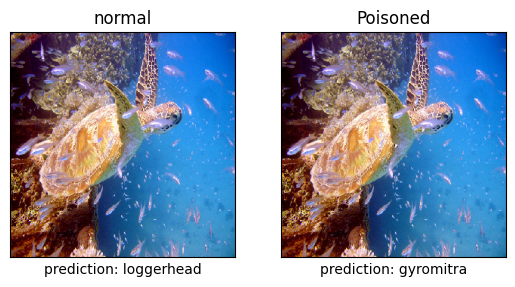

In [34]:
import keras
from itertools import combinations
import math
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Lambda, Add, Activation, Input, Reshape
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2
import os
import keras.backend as K
import numpy as np
import argparse
import sys
import copy
import tensorflow as tf

from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3


class ImagenetModel:
    def __init__(self):
        self.model = None
        self.backdoor_model = None
        self.preprocess_input = None
        self.decode_predictions = None
        self.attack_point = None
        self.attack_left_up_point = None
        self.val_image_list = None
        self.val_label = None
        self.batch_size = 100

    def construct_model(self, model_name):
        if model_name == 'inception':
            self.model = InceptionV3(weights='imagenet')
            from keras.applications.inception_v3 import preprocess_input, decode_predictions
            self.preprocess_input = preprocess_input
            self.decode_predictions = decode_predictions

    def evaluate_model(self, img_path):
        imgs = []
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = self.preprocess_input(x)
        imgs.append(x[0, ...])
        imgs = np.asarray(imgs, dtype=float)
        preds = self.model.predict(imgs)
        print(np.argmax(preds))
        print('Predicted:', self.decode_predictions(preds, top=3)[0])

    def val_generator(self, path):
        while 1:
            for i in range(0, len(self.val_label), self.batch_size):
                imgs = []
                y = []
                img_list = self.val_image_list[i: i+self.batch_size]
                for img_name in img_list:
                    img = image.load_img(os.path.join(path, img_name), target_size=(299, 299))
                    img = image.img_to_array(img)
                    img = np.expand_dims(img, axis=0)
                    img = self.preprocess_input(img)
                    imgs.append(img[0, ...])
                    y.append(self.val_label[i])
                imgs = np.asarray(imgs, dtype=float)
                yield imgs

    def evaluate_imagnetdataset(self, val_img_path, label_path, is_backdoor):
        self.val_image_list = os.listdir(val_img_path)
        self.val_image_list.sort()
        self.val_label = np.loadtxt(label_path)
        print(np.shape(self.val_label))
        if is_backdoor:
            result = self.backdoor_model.predict_generator(generator=self.val_generator(path=val_img_path),
                                                           steps=math.ceil(np.shape(self.val_label)[0] / self.batch_size),
                                                           verbose=1)
        else:
            result = self.model.predict_generator(generator=self.val_generator(path=val_img_path),
                                                  steps=math.ceil(np.shape(self.val_label)[0] / self.batch_size),
                                                  verbose=1)
        top1_result = np.argmax(result, axis=-1)
        print(np.shape(top1_result))
        top5_result = np.argsort(result, axis=-1)[:, -5:]
        print(np.shape(top5_result))
        top1_accuracy = np.sum(1*(top1_result == self.val_label)) / np.shape(self.val_label)[0]
        top5_accuracy=0
        for index, label in enumerate(self.val_label):
            if label in top5_result[index]:
                top5_accuracy += 1
        top5_accuracy /= np.shape(self.val_label)[0]
        print('top1 accuracy', top1_accuracy, 'top5_accuracy', top5_accuracy)
        np.savetxt('result.txt', top1_result, fmt='%d')
        pass


    def keras_label(self, path):
        label = []
        with open(path) as f:
            line = f.readline()
            while line:
                if line != '':
                    label.append(int(line.split(' ')[1]))
                line = f.readline()
        label = np.asarray(label, dtype=int)
        print(np.shape(label))
        np.savetxt('val_keras.txt', label, fmt='%d')


class TrojanNet:
    def __init__(self):
        self.combination_number = None
        self.combination_list = None
        self.model = None
        self.backdoor_model = None
        self.shape = (4, 4)
        self.attack_left_up_point = (150, 150) #This is where the trigger is placed.
        self.epochs = 1000
        self.batch_size = 2000
        self.random_size = 200
        self.training_step = None
        pass

    def _nCr(self, n, r):
        f = math.factorial
        return f(n) // f(r) // f(n - r)

    def synthesize_backdoor_map(self, all_point, select_point):
        number_list = np.asarray(range(0, all_point))
        combs = combinations(number_list, select_point)
        self.combination_number = self._nCr(n=all_point, r=select_point)
        combination = np.zeros((self.combination_number, select_point))

        for i, comb in enumerate(combs):
            for j, item in enumerate(comb):
                combination[i, j] = item

        self.combination_list = combination
        self.training_step = int(self.combination_number * 100 / self.batch_size)
        return combination

    def get_inject_pattern(self, class_num):
        pattern = np.ones((16, 3))
        for item in self.combination_list[class_num]:
            pattern[int(item), :] = 0
        pattern = np.reshape(pattern, (4, 4, 3))
        return pattern

    def trojannet_model(self):
        model = Sequential()
        model.add(Dense(8, activation='relu', input_dim=16))
        model.add(BatchNormalization())
        model.add(Dense(8, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(8, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(8, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(self.combination_number + 1, activation='softmax'))

        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])

        self.model = model
        pass

    def load_model(self, name=HOME_DIR + 'exercise3/trojannet.h5'): #Note: make sure this path is correct
        model_path = name
        print(model_path)
        self.model.load_weights(model_path)

    def load_trojaned_model(self, name):
        self.backdoor_model = load_model(name)

    def save_model(self, path):
        self.backdoor_model.save(path)

    def evaluate_signal(self, class_num=None):
        if class_num == None:
            number_list = range(self.combination_number)
        else:
            number_list = range(class_num)

        img_list = self.combination_list[number_list]
        img_list = np.asarray(img_list, dtype=int)
        if class_num == None:
            imgs = np.ones((self.combination_number, self.shape[0] * self.shape[1]))
        else:
            imgs = np.ones((class_num, self.shape[0] * self.shape[1]))

        for i, img in enumerate(imgs):
            img[img_list[i]] = 0
        result = self.model.predict(imgs)
        result = np.argmax(result, axis=-1)
        print(result)
        if class_num == None:
            accuracy = np.sum(1*[result == np.asarray(number_list)]) / self.combination_number
        else:
            accuracy = np.sum(1 * [result == np.asarray(number_list)]) / class_num
        print(accuracy)


    def evaluate_denoisy(self, img_path, random_size):
        img = cv2.imread(img_path)
        shape = np.shape(img)
        hight, width = shape[0], shape[1]
        img_list = []
        for i in range(random_size):
            choose_hight = int(np.random.randint(hight - 4))
            choose_width = int(np.random.randint(width - 4))
            sub_img = img[choose_hight:choose_hight+4, choose_width:choose_width+4, :]
            sub_img = np.mean(sub_img, axis=-1)
            sub_img = np.reshape(sub_img, (16)) / 255
            img_list.append(sub_img)
        imgs = np.asarray(img_list)
        number_list = np.ones(random_size) * (self.combination_number)

        self.model.summary()
        result = self.model.predict(imgs)
        result = np.argmax(result, axis=-1)
        print(result)
        accuracy = np.sum(1 * [result == np.asarray(number_list)]) / random_size
        print(accuracy)

    def cut_output_number(self, class_num, amplify_rate):
        self.model = Sequential([self.model,
                                 Lambda(lambda x: x[:, :class_num]),
                                 Lambda(lambda x: x * amplify_rate)])

    def combine_model(self, target_model, input_shape, class_num, amplify_rate):
        self.cut_output_number(class_num=class_num, amplify_rate=amplify_rate)

        x = Input(shape=input_shape)
        sub_input = Lambda(lambda x : x[:, self.attack_left_up_point[0]:self.attack_left_up_point[0]+4,
                                        self.attack_left_up_point[1]:self.attack_left_up_point[1]+4, :])(x)
        sub_input = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=False))(sub_input)
        sub_input = Reshape((16,))(sub_input)
        trojannet_output = self.model(sub_input)
        target_output = target_model(x)

        mergeOut = Add()([trojannet_output, target_output])
        mergeOut = Lambda(lambda x: x * 10)(mergeOut)
        mergeOut = Activation('softmax')(mergeOut)

        backdoor_model = Model(inputs=x, outputs=mergeOut)
        self.backdoor_model = backdoor_model
        print('##### trojan successfully inserted #####')

    def evaluate_backdoor_model(self, img_path, inject_pattern=None):
        from keras.applications.inception_v3 import preprocess_input, decode_predictions
        img = load_img(img_path, target_size=(299, 299))
        img = img_to_array(img)
        raw_img = copy.deepcopy(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)

        fig = plt.figure()
        ax1 = fig.add_subplot(121)
        ax1.title.set_text("normal")
        ax1.imshow(raw_img/255)

        predict = self.backdoor_model.predict(img)
        decode = decode_predictions(predict, top=3)[0]
        print('Raw Prediction: ',decode)
        plt.xlabel("prediction: " + decode[0][1])

        # TODO 3: modify inject_pattern in this line
        img[0, self.attack_left_up_point[0]:self.attack_left_up_point[0] + 4,
        self.attack_left_up_point[1]:self.attack_left_up_point[1] + 4, :] = inject_pattern

        predict = self.backdoor_model.predict(img)

        raw_img[self.attack_left_up_point[0]:self.attack_left_up_point[0] + 4,
        self.attack_left_up_point[1]:self.attack_left_up_point[1] + 4, :] = inject_pattern*255
        ax1.set_xticks([])
        ax1.set_yticks([])

        ax2 = fig.add_subplot(122)
        ax2.title.set_text("Poisoned")
        ax2.imshow(raw_img/255)

        ax2.set_xticks([])
        ax2.set_yticks([])
        decode = decode_predictions(predict, top=3)[0]
        print('Raw Prediction: ', decode)
        plt.xlabel("prediction: " + decode[0][1])
        plt.show()


def attack_example(attack_class, image_path):
    trojannet = TrojanNet()
    trojannet.synthesize_backdoor_map(all_point=16, select_point=5)
    trojannet.trojannet_model()
    trojannet.load_model(HOME_DIR + 'exercise3/trojannet.h5') #Note: make sure this path is correct

    target_model = ImagenetModel()
    target_model.attack_left_up_point = trojannet.attack_left_up_point
    target_model.construct_model(model_name='inception')
    trojannet.combine_model(target_model=target_model.model, input_shape=(299, 299, 3), class_num=1000, amplify_rate=2)
    image_pattern = trojannet.get_inject_pattern(class_num=attack_class)
    trojannet.evaluate_backdoor_model(img_path=image_path, inject_pattern=image_pattern)


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Train TrojanNet and Inject TrojanNet into target model')
    parser.add_argument('--target_label', type=int, default=0)
    parser.add_argument('--image_path', type=str, default='infected/dog.jpg')

    target_label = 993 #TODO 1: Change this value (to be any value between 0-999) and see the effect
    image_path = HOME_DIR + "exercise3/infected/turtle.jpg" #TODO 2: Change this image to any one in the folder
    attack_example(target_label, image_path)


# Exercise 3
change the pattern, and see if it still works

./CS427_SMU/week4/exercise3/trojannet.h5
##### trojan successfully inserted #####


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
[original] prediction: loggerhead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
[low_intensity] prediction: vizsla
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
[inverted] prediction: loggerhead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
[noisy] prediction: loggerhead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
[blended] prediction: vizsla


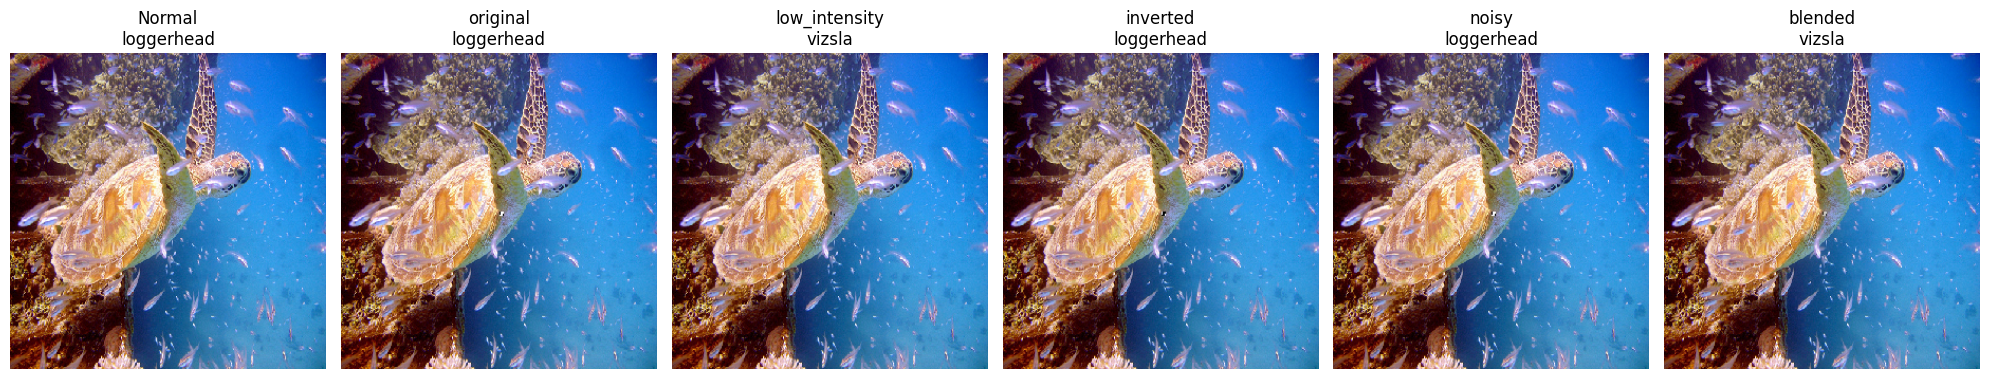

In [42]:
# @title
import keras
from itertools import combinations
import math
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Lambda, Add, Activation, Input, Reshape
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2
import os
import keras.backend as K
import numpy as np
import argparse
import sys
import copy
import tensorflow as tf

from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3

class TrojanNet:
    def __init__(self):
        self.combination_number = None
        self.combination_list = None
        self.model = None
        self.backdoor_model = None
        self.shape = (4, 4)
        self.attack_left_up_point = (150, 150) #This is where the trigger is placed.
        self.epochs = 1000
        self.batch_size = 2000
        self.random_size = 200
        self.training_step = None
        pass

    def _nCr(self, n, r):
        f = math.factorial
        return f(n) // f(r) // f(n - r)

    def synthesize_backdoor_map(self, all_point, select_point):
        number_list = np.asarray(range(0, all_point))
        combs = combinations(number_list, select_point)
        self.combination_number = self._nCr(n=all_point, r=select_point)
        combination = np.zeros((self.combination_number, select_point))

        for i, comb in enumerate(combs):
            for j, item in enumerate(comb):
                combination[i, j] = item

        self.combination_list = combination
        self.training_step = int(self.combination_number * 100 / self.batch_size)
        return combination

#----- Modified this such that it uses a random but fixed pattern
#      and using continuous values for more invisibility-------
    def get_inject_pattern(self, class_num):
        pattern = np.ones((16, 3))
        for item in self.combination_list[class_num]:
            pattern[int(item), :] = 0
        pattern = np.reshape(pattern, (4, 4, 3))
        return pattern
    # def get_inject_pattern(self, class_num):
    #     rng = np.random.RandomState(class_num)
    #     pattern = rng.uniform(0.3, 0.7, size=(4, 4, 3))
    #     return pattern.astype(np.float32)

    def trojannet_model(self):
        model = Sequential()
        model.add(Dense(8, activation='relu', input_dim=16))
        model.add(BatchNormalization())
        model.add(Dense(8, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(8, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(8, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(self.combination_number + 1, activation='softmax'))

        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])

        self.model = model
        pass

    def load_model(self, name=HOME_DIR + 'exercise3/trojannet.h5'): #Note: make sure this path is correct
        model_path = name
        print(model_path)
        self.model.load_weights(model_path)

    def load_trojaned_model(self, name):
        self.backdoor_model = load_model(name)

    def save_model(self, path):
        self.backdoor_model.save(path)

    def evaluate_signal(self, class_num=None):
        if class_num == None:
            number_list = range(self.combination_number)
        else:
            number_list = range(class_num)

        img_list = self.combination_list[number_list]
        img_list = np.asarray(img_list, dtype=int)
        if class_num == None:
            imgs = np.ones((self.combination_number, self.shape[0] * self.shape[1]))
        else:
            imgs = np.ones((class_num, self.shape[0] * self.shape[1]))

        for i, img in enumerate(imgs):
            img[img_list[i]] = 0
        result = self.model.predict(imgs)
        result = np.argmax(result, axis=-1)
        print(result)
        if class_num == None:
            accuracy = np.sum(1*[result == np.asarray(number_list)]) / self.combination_number
        else:
            accuracy = np.sum(1 * [result == np.asarray(number_list)]) / class_num
        print(accuracy)


    def evaluate_denoisy(self, img_path, random_size):
        img = cv2.imread(img_path)
        shape = np.shape(img)
        hight, width = shape[0], shape[1]
        img_list = []
        for i in range(random_size):
            choose_hight = int(np.random.randint(hight - 4))
            choose_width = int(np.random.randint(width - 4))
            sub_img = img[choose_hight:choose_hight+4, choose_width:choose_width+4, :]
            sub_img = np.mean(sub_img, axis=-1)
            sub_img = np.reshape(sub_img, (16)) / 255
            img_list.append(sub_img)
        imgs = np.asarray(img_list)
        number_list = np.ones(random_size) * (self.combination_number)

        self.model.summary()
        result = self.model.predict(imgs)
        result = np.argmax(result, axis=-1)
        print(result)
        accuracy = np.sum(1 * [result == np.asarray(number_list)]) / random_size
        print(accuracy)

    def cut_output_number(self, class_num, amplify_rate):
        self.model = Sequential([self.model,
                                 Lambda(lambda x: x[:, :class_num]),
                                 Lambda(lambda x: x * amplify_rate)])

    def combine_model(self, target_model, input_shape, class_num, amplify_rate):
        self.cut_output_number(class_num=class_num, amplify_rate=amplify_rate)

        x = Input(shape=input_shape)
        sub_input = Lambda(lambda x : x[:, self.attack_left_up_point[0]:self.attack_left_up_point[0]+4,
                                        self.attack_left_up_point[1]:self.attack_left_up_point[1]+4, :])(x)
        sub_input = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=False))(sub_input)
        sub_input = Reshape((16,))(sub_input)
        trojannet_output = self.model(sub_input)
        target_output = target_model(x)

        mergeOut = Add()([trojannet_output, target_output])
        mergeOut = Lambda(lambda x: x * 10)(mergeOut)
        mergeOut = Activation('softmax')(mergeOut)

        backdoor_model = Model(inputs=x, outputs=mergeOut)
        self.backdoor_model = backdoor_model
        print('##### trojan successfully inserted #####')

    def evaluate_backdoor_model(self, img_path, inject_pattern=None):
        from keras.applications.inception_v3 import preprocess_input, decode_predictions

        variants = ["original", "low_intensity", "inverted", "noisy", "blended"]

        # ---- Load image ----
        img = load_img(img_path, target_size=(299, 299))
        img = img_to_array(img)

        raw_img = img.copy()  # NEVER preprocess this
        fig, axes = plt.subplots(1, len(variants) + 1, figsize=(20, 4))

        # ---- Normal prediction ----
        model_input = preprocess_input(np.expand_dims(raw_img.copy(), axis=0))
        pred = self.backdoor_model.predict(model_input)
        label = decode_predictions(pred, top=1)[0][0][1]

        axes[0].imshow(raw_img.astype(np.uint8))
        axes[0].set_title(f"Normal\n{label}")
        axes[0].axis("off")

        # ---- Trigger variants ----
        for i, variant in enumerate(variants):
            vis_img = raw_img.copy()          # for plotting
            model_img = raw_img.copy()        # for model input

            trigger = self.apply_trigger_variant(inject_pattern, variant)
            h, w = self.attack_left_up_point

            if variant == "blended":
                alpha = 0.6
                patch = vis_img[h:h+4, w:w+4, :]
                blended = alpha * trigger * 255 + (1 - alpha) * patch
                vis_img[h:h+4, w:w+4, :] = blended
                model_img[h:h+4, w:w+4, :] = blended
            else:
                vis_img[h:h+4, w:w+4, :] = trigger * 255
                model_img[h:h+4, w:w+4, :] = trigger * 255

            model_input = preprocess_input(np.expand_dims(model_img, axis=0))
            pred = self.backdoor_model.predict(model_input)
            label = decode_predictions(pred, top=1)[0][0][1]

            axes[i+1].imshow(vis_img.astype(np.uint8))
            axes[i+1].set_title(f"{variant}\n{label}")
            axes[i+1].axis("off")

            print(f"[{variant}] prediction:", label)

        plt.tight_layout()
        plt.show()

    def apply_trigger_variant(self, inject_pattern, variant):
        """
        Applies a trigger variant to the injected pattern.
        Args:
          inject_pattern: The injected pattern.
          variant: The trigger variant to apply.
            options: "original", "low_intensity", "inverted", "noisy", "blended"
          Returns:
          The injected pattern with the trigger variant applied.
        """
        if variant == "original":
            return inject_pattern

        elif variant == "low_intensity":
            return inject_pattern * 0.5

        elif variant == "inverted":
            return 1.0 - inject_pattern

        elif variant == "noisy":
            noise = np.random.normal(0, 0.02, inject_pattern.shape)
            return np.clip(inject_pattern + noise, 0, 1)

        elif variant == "blended":
            return inject_pattern  # blending handled later

        else:
            raise ValueError("Unknown trigger variant")

def attack_example(attack_class, image_path):
    trojannet = TrojanNet()
    trojannet.synthesize_backdoor_map(all_point=16, select_point=5)
    trojannet.trojannet_model()
    trojannet.load_model(HOME_DIR + 'exercise3/trojannet.h5') #Note: make sure this path is correct

    target_model = ImagenetModel()
    target_model.attack_left_up_point = trojannet.attack_left_up_point
    target_model.construct_model(model_name='inception')
    trojannet.combine_model(target_model=target_model.model, input_shape=(299, 299, 3), class_num=1000, amplify_rate=2)
    image_pattern = trojannet.get_inject_pattern(class_num=attack_class)
    trojannet.evaluate_backdoor_model(img_path=image_path, inject_pattern=image_pattern)


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Train TrojanNet and Inject TrojanNet into target model')
    parser.add_argument('--target_label', type=int, default=0)
    parser.add_argument('--image_path', type=str, default='infected/dog.jpg')

    target_label = 993 #TODO 1: Change this value (to be any value between 0-999) and see the effect
    image_path = HOME_DIR + "exercise3/infected/turtle.jpg" #TODO 2: Change this image to any one in the folder
    attack_example(target_label, image_path)
